In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [2]:
import kagglehub


path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:

for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
    
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path


random.seed(42)


source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

   
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

   
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),     
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [7]:
class_names = dataset.classes
num_classes = len(class_names)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.googlenet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 68.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [9]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
from time import perf_counter
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler  
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 50  

model = models.googlenet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  

early_stopping = EarlyStopping(patience=5)  
train_losses, val_losses = [], []  

scaler = GradScaler()

total_train_t0 = perf_counter()
epoch_times = []

for epoch in range(num_epochs):
    t_epoch0 = perf_counter()
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    t_epoch1 = perf_counter()
    epoch_times.append(t_epoch1 - t_epoch0)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f} s")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

total_train_t1 = perf_counter()
total_training_time_s = total_train_t1 - total_train_t0
avg_epoch_time_s = (sum(epoch_times)/len(epoch_times)) if epoch_times else float('nan')

print(f"\nTotal training time: {total_training_time_s:.2f} s")
print(f"Average per-epoch time: {avg_epoch_time_s:.2f} s")


/tmp/ipykernel_19/1594847195.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_19/1594847195.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_19/1594847195.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train Loss: 1.6940, Validation Loss: 0.7773
Epoch 1 time: 34.55 s
Epoch 2/50


Train Loss: 0.6773, Validation Loss: 0.4796
Epoch 2 time: 33.87 s
Epoch 3/50


Train Loss: 0.4824, Validation Loss: 0.3837
Epoch 3 time: 34.09 s
Epoch 4/50


Train Loss: 0.4028, Validation Loss: 0.3389
Epoch 4 time: 34.07 s
Epoch 5/50


Train Loss: 0.3481, Validation Loss: 0.3074
Epoch 5 time: 33.82 s
Epoch 6/50


Train Loss: 0.3126, Validation Loss: 0.2864
Epoch 6 time: 33.93 s
Epoch 7/50


Train Loss: 0.2852, Validation Loss: 0.2728
Epoch 7 time: 34.10 s
Epoch 8/50


Train Loss: 0.2607, Validation Loss: 0.2676
Epoch 8 time: 33.77 s
Epoch 9/50


Train Loss: 0.2448, Validation Loss: 0.2417
Epoch 9 time: 33.92 s
Epoch 10/50


Train Loss: 0.2279, Validation Loss: 0.2411
Epoch 10 time: 33.79 s
Epoch 11/50


Train Loss: 0.2129, Validation Loss: 0.2381
Epoch 11 time: 33.94 s
Epoch 12/50


Train Loss: 0.2061, Validation Loss: 0.2267
Epoch 12 time: 34.19 s
Epoch 13/50


Train Loss: 0.1977, Validation Loss: 0.2263
Epoch 13 time: 34.47 s
Epoch 14/50


Train Loss: 0.1897, Validation Loss: 0.2365
Epoch 14 time: 34.64 s
Epoch 15/50


Train Loss: 0.1801, Validation Loss: 0.2239
Epoch 15 time: 34.34 s
Epoch 16/50


Train Loss: 0.1774, Validation Loss: 0.2210
Epoch 16 time: 34.26 s
Epoch 17/50


Train Loss: 0.1720, Validation Loss: 0.2177
Epoch 17 time: 34.38 s
Epoch 18/50


Train Loss: 0.1693, Validation Loss: 0.2161
Epoch 18 time: 33.90 s
Epoch 19/50


Train Loss: 0.1678, Validation Loss: 0.2107
Epoch 19 time: 34.09 s
Epoch 20/50


Train Loss: 0.1552, Validation Loss: 0.2108
Epoch 20 time: 33.88 s
Epoch 21/50


Train Loss: 0.1479, Validation Loss: 0.2050
Epoch 21 time: 34.13 s
Epoch 22/50


Train Loss: 0.1536, Validation Loss: 0.2037
Epoch 22 time: 34.37 s
Epoch 23/50


Train Loss: 0.1477, Validation Loss: 0.2215
Epoch 23 time: 34.45 s
Epoch 24/50


Train Loss: 0.1523, Validation Loss: 0.2089
Epoch 24 time: 34.10 s
Epoch 25/50


Train Loss: 0.1463, Validation Loss: 0.2106
Epoch 25 time: 34.14 s
Epoch 26/50


Train Loss: 0.1354, Validation Loss: 0.2110
Epoch 26 time: 33.99 s
Epoch 27/50


Train Loss: 0.1382, Validation Loss: 0.2034
Epoch 27 time: 34.01 s
Epoch 28/50


Train Loss: 0.1367, Validation Loss: 0.2136
Epoch 28 time: 34.10 s
Epoch 29/50


Train Loss: 0.1447, Validation Loss: 0.2065
Epoch 29 time: 33.86 s
Epoch 30/50


Train Loss: 0.1368, Validation Loss: 0.1970
Epoch 30 time: 33.90 s
Epoch 31/50


Train Loss: 0.1303, Validation Loss: 0.2125
Epoch 31 time: 33.81 s
Epoch 32/50


Train Loss: 0.1296, Validation Loss: 0.1938
Epoch 32 time: 33.98 s
Epoch 33/50


Train Loss: 0.1280, Validation Loss: 0.1997
Epoch 33 time: 33.82 s
Epoch 34/50


Train Loss: 0.1290, Validation Loss: 0.1856
Epoch 34 time: 34.02 s
Epoch 35/50


Train Loss: 0.1272, Validation Loss: 0.2033
Epoch 35 time: 33.93 s
Epoch 36/50


Train Loss: 0.1257, Validation Loss: 0.2111
Epoch 36 time: 34.00 s
Epoch 37/50


Train Loss: 0.1298, Validation Loss: 0.1978
Epoch 37 time: 34.03 s
Epoch 38/50


Train Loss: 0.1245, Validation Loss: 0.2036
Epoch 38 time: 34.14 s
Epoch 39/50


Train Loss: 0.1289, Validation Loss: 0.2015
Epoch 39 time: 34.10 s
Early stopping triggered.

Total training time: 1328.86 s
Average per-epoch time: 34.07 s


In [11]:

model_save_path = "googlenet_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to googlenet_model.pth


In [12]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_19/2379966855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8649    0.9552    0.9078        67
           1     0.9667    1.0000    0.9831        58
           2     1.0000    0.9189    0.9577        74
           3     1.0000    0.9867    0.9933        75
           4     0.9718    0.9583    0.9650        72
           5     0.9831    0.9667    0.9748        60
           6     0.9206    0.7945    0.8529        73
           7     1.0000    1.0000    1.0000        70
           8     0.8295    0.9359    0.8795        78
           9     1.0000    1.0000    1.0000        68
          10     0.9545    0.9545    0.9545        66
          11     0.9859    0.9589    0.9722        73
          12     0.9733    0.9865    0.9799        74
          13     1.0000    1.0000    1.0000        81
          14     0.9863    0.9863    0.9863        73
          15     0.9420    0.9559    0.9489        68
          16     0.9701    1.0000    0.9848        65
   

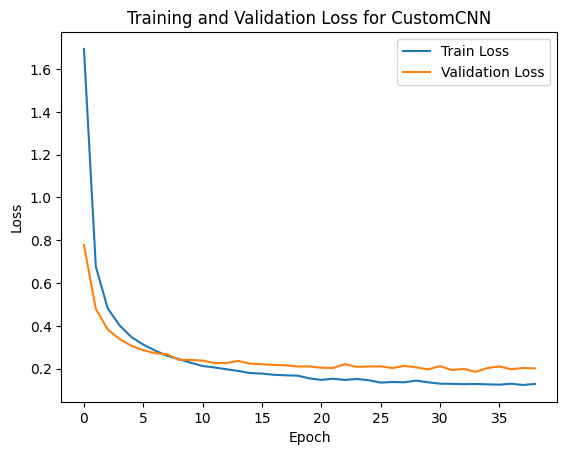

In [13]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_19/1362086699.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Testing time: 3.72 sec  |  Throughput: 339.16 samples/sec
Confusion Matrix:
 [[38  0  0 ...  0  0  0]
 [ 0 37  0 ...  0  0  0]
 [ 1  0 33 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0 26  0]
 [ 0  0  0 ...  0  1 37]]

Confusion Matrix (row-normalized):
[[0.95  0.    0.    ... 0.    0.    0.   ]
 [0.    0.974 0.    ... 0.    0.    0.   ]
 [0.029 0.    0.943 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 1.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.963 0.   ]
 [0.    0.    0.    ... 0.    0.026 0.949]]


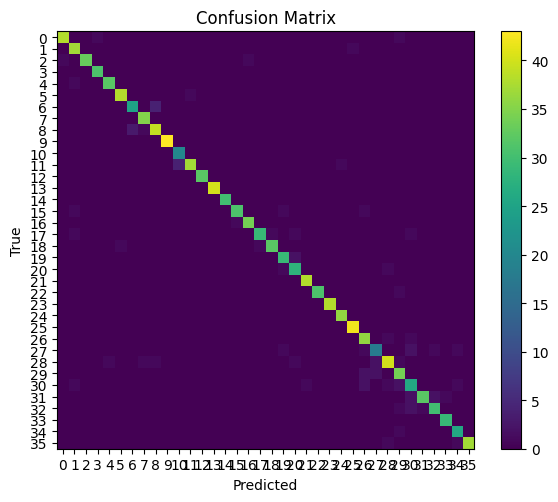

Per-class ROC AUC:
  Class 0: 0.9998
  Class 1: 0.9998
  Class 2: 0.9998
  Class 3: 1.0000
  Class 4: 0.9998
  Class 5: 0.9998
  Class 6: 0.9988
  Class 7: 1.0000
  Class 8: 0.9988
  Class 9: 1.0000
  Class 10: 0.9998
  Class 11: 0.9996
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 1.0000
  Class 15: 0.9996
  Class 16: 0.9997
  Class 17: 0.9992
  Class 18: 0.9998
  Class 19: 0.9998
  Class 20: 0.9997
  Class 21: 1.0000
  Class 22: 0.9999
  Class 23: 1.0000
  Class 24: 0.9999
  Class 25: 1.0000
  Class 26: 0.9985
  Class 27: 0.9878
  Class 28: 0.9949
  Class 29: 0.9967
  Class 30: 0.9961
  Class 31: 0.9995
  Class 32: 0.9971
  Class 33: 1.0000
  Class 34: 0.9998
  Class 35: 1.0000
Micro-average ROC AUC: 0.9995
Macro-average ROC AUC: 0.9991


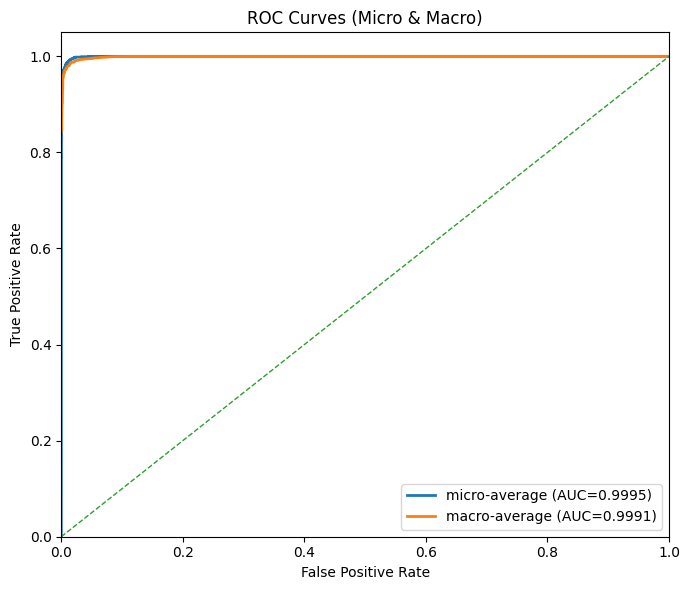

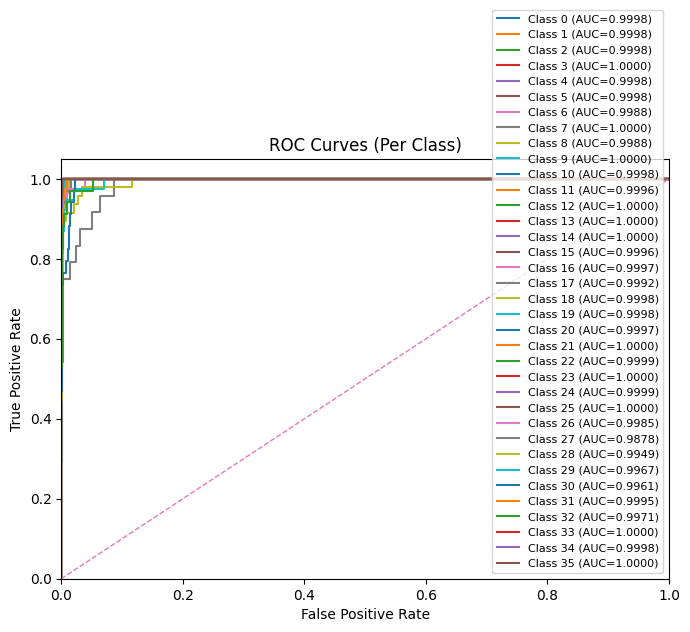


Classification Report (test):
              precision    recall  f1-score   support

           0     0.9744    0.9500    0.9620        40
           1     0.9024    0.9737    0.9367        38
           2     1.0000    0.9429    0.9706        35
           3     0.9688    1.0000    0.9841        31
           4     0.9697    0.9697    0.9697        33
           5     0.9744    0.9744    0.9744        39
           6     0.8929    0.8621    0.8772        29
           7     0.9459    1.0000    0.9722        35
           8     0.8864    0.9070    0.8966        43
           9     1.0000    1.0000    1.0000        43
          10     0.8333    1.0000    0.9091        20
          11     0.9737    0.8810    0.9250        42
          12     1.0000    1.0000    1.0000        32
          13     1.0000    1.0000    1.0000        40
          14     1.0000    1.0000    1.0000        30
          15     0.9688    0.9118    0.9394        34
          16     0.9714    0.9714    0.9714       

In [14]:
from time import perf_counter
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits = []
all_probs = []
all_preds = []
all_labels = []

loader = test_loader

t_test_start = time.time()
with torch.no_grad():
    test_t0 = perf_counter()
    n_images_tested = 0
    for images, labels in loader:
        n_images_tested += images.size(0)
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(images)
            probs = F.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score = all_probs

if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))

test_t1 = perf_counter()
total_test_time_s = test_t1 - test_t0
avg_per_image_ms = (total_test_time_s / max(1, n_images_tested)) * 1000.0
print(f"\nTotal test inference time: {total_test_time_s:.2f} s for {n_images_tested} images")
print(f"Average per-image inference time: {avg_per_image_ms:.2f} ms")

In [15]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-h380riok
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-h380riok
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

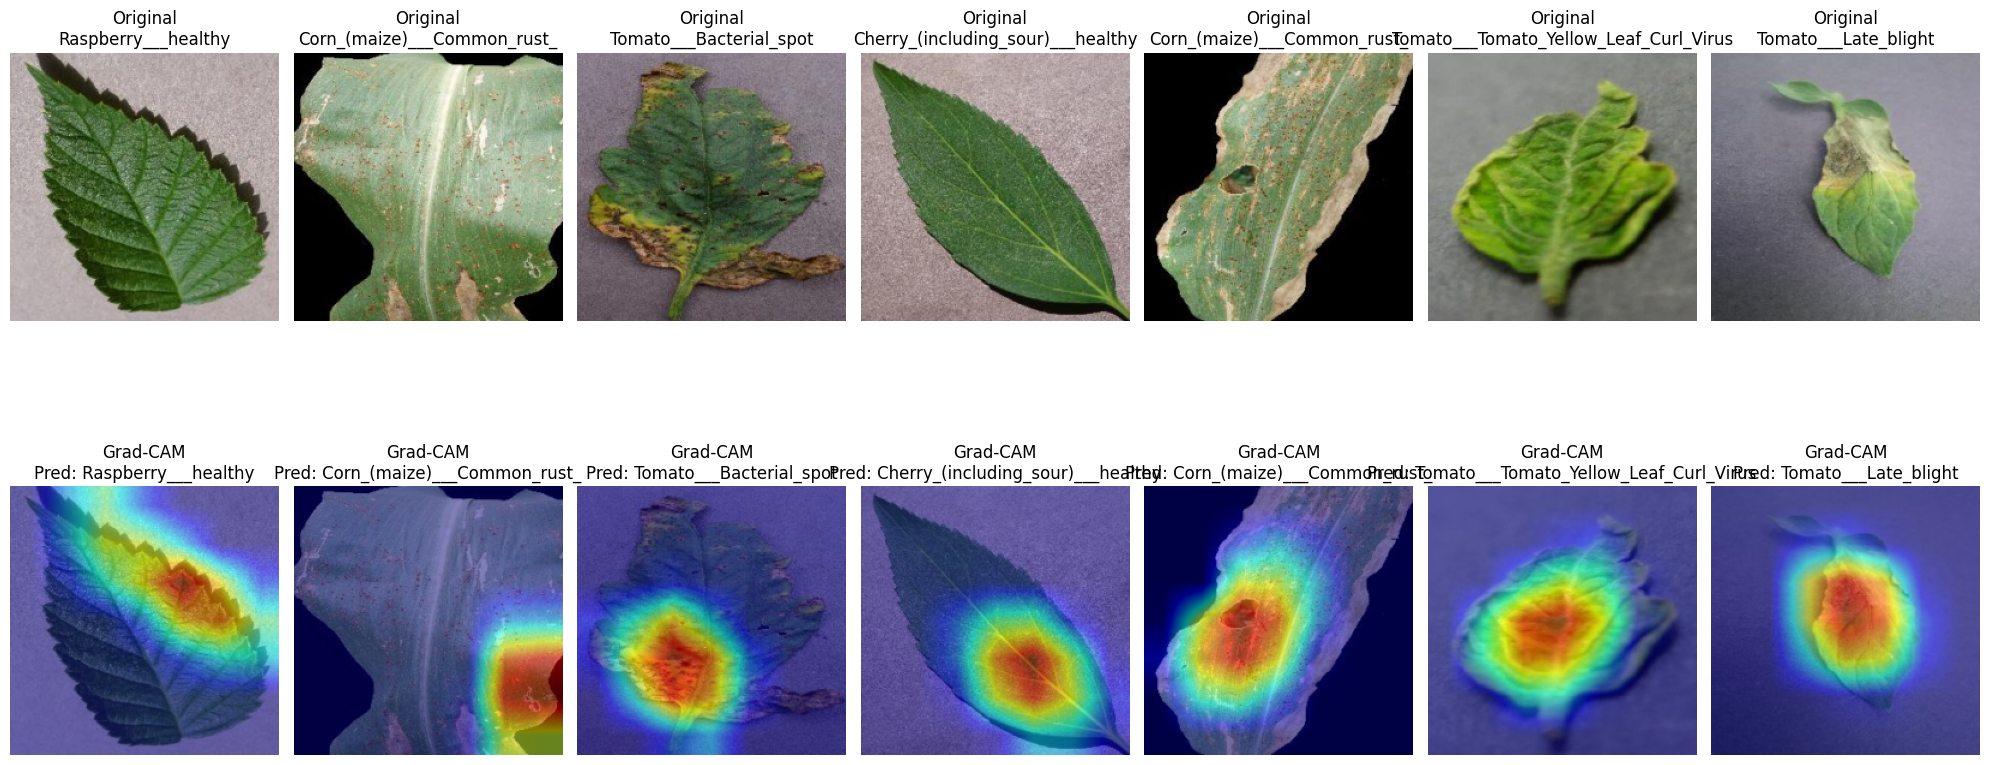

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.inception5b.parameters():
    p.requires_grad_(True)


target_layers = [model.inception5b]
cam = GradCAM(model=model, target_layers=target_layers)


plt.figure(figsize=(20, 10))

for idx in range(7):
    sample_image, label = test_dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)


    original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    original_image_np = (original_image_np * 0.5) + 0.5   # denormalize
    original_image_np = original_image_np.clip(0, 1)


    outputs = model(sample_image)
    predicted_class = outputs.argmax(dim=1).item()


    targets = [ClassifierOutputTarget(predicted_class)]


    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]

    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

    # Plot result
    plt.subplot(2, 7, idx+1)
    plt.title(f"Original\n{class_names[label]}")
    plt.imshow(original_image_np)
    plt.axis('off')

    plt.subplot(2, 7, idx+1+7)
    plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]}")
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()
